In [61]:
!pip install pandas numpy matplotlib seaborn beautifulsoup4 lxml nltk spacy transformers textblob vaderSentiment

In [62]:
import os
import pandas as pd
import glob
from bs4 import BeautifulSoup


In [63]:
def parse_car_meta(filename):
    parts = filename.split("_")

    year = parts[0]
    brand = parts[1]
    model = parts[2]

    return year, brand, model


In [64]:
base_dir = './data/cars'

In [65]:
def read_file_content(file_path):
    """Read file content with encoding error handling."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            return file.read()
    except UnicodeDecodeError:
        # Fallback to latin-1 if utf-8 fails
        with open(file_path, 'r', encoding='latin-1') as file:
            return file.read()

def extract_metadata(filename):
    """Extract and parse car metadata from soup."""
    # docno = soup.find_all('docno')
    return parse_car_meta(filename) if filename else ("Unknown", "Unknown", "Unknown") #

def process_review_document(doc, meta):
    """Process a single review document and extract its data."""
    date_tag = doc.find("date")
    author_tag = doc.find("author")
    text_tag = doc.find("text")
    favorite_tag = doc.find("favorite")

    # Extract text content, handle missing tags
    date_str = date_tag.text if date_tag else None
    # Convert date string to datetime object with American format (MM/DD/YYYY)
    date = pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce') if date_str else None
    author = author_tag.text if author_tag else None
    text = text_tag.text if text_tag else None
    favorite = favorite_tag.text if favorite_tag else None

    return {
        "DATE": date,
        "AUTHOR": author,
        "TEXT": text,
        "FAVORITE": favorite,
        "MODEL": meta[2],
        "BRAND": meta[1],
        "YEAR_MADE": meta[0]  # Changed from "YEAR" to "YEAR_MADE"
    }

def parse_review_file(file_path):
    """Parse a review file and return a DataFrame of reviews."""
    # Read the file content
    file_content = read_file_content(file_path)
    
    # Create BeautifulSoup object
    soup = BeautifulSoup("<root>" + file_content + "</root>", 'html.parser')
    
    # Extract metadata and documents
    filename = os.path.basename(file_path)
    meta = extract_metadata(filename)
    docs = soup.find_all('doc')
    
    # Process each review document
    reviews = [process_review_document(doc, meta) for doc in docs]
    
    # Create and return DataFrame
    return pd.DataFrame(reviews)

In [66]:
def parse_all_reviews(base_dir='./data/cars'):
    """
    Parse all car reviews in the base directory structure.
    
    Args:
        base_dir (str): Base directory containing the car review files
        
    Returns:
        pd.DataFrame: Combined DataFrame with all reviews
    """
    # Initialize collection and statistics
    dataframes = []
    total_files = 0
    total_errors = 0
    
    # Process all directories and files
    for year in os.listdir(base_dir):
        year_path = os.path.join(base_dir, year)
        
        # Skip if not a directory
        if not os.path.isdir(year_path):
            continue
            
        print(f"Processing directory: {year}")
        
        # Process each file in the year directory
        for file_name in os.listdir(year_path):
            file_path = os.path.join(year_path, file_name)
            
            # Skip if not a file
            if not os.path.isfile(file_path):
                continue
                
            try:
                # Parse the file into a DataFrame
                df = parse_review_file(file_path)
                dataframes.append(df)
                total_files += 1
                print(f"  Processed {file_path}: found {len(df)} reviews")
                
            except Exception as e:
                total_errors += 1
                print(f"  Error processing {file_path}: {str(e)}")
    
    # Combine all dataframes
    if dataframes:
        reviews_df = pd.concat(dataframes, ignore_index=True)
        
        # Print statistics
        print(f"\nTotal files processed: {total_files}")
        print(f"Total files with errors: {total_errors}")
        print(f"Total reviews extracted: {len(reviews_df)}")
        
        return reviews_df
    else:
        print("No review data found.")
        return pd.DataFrame()

In [67]:

# Parse all reviews and get the resulting DataFrame
reviews_df = parse_all_reviews(base_dir)

# Print/display the DataFrame
print("\nReview Data Sample:")
print(reviews_df.head())

# Print basic statistics
print("\nDataFrame Info:")
print(reviews_df.info())

print("\nSummary Statistics:")
print(reviews_df.describe(include='all'))

Processing directory: 2008
  Processed ./data/cars/2008/2008_bmw_x5: found 48 reviews
  Processed ./data/cars/2008/2008_gmc_yukon_hybrid: found 14 reviews
  Processed ./data/cars/2008/2008_chevrolet_suburban: found 25 reviews
  Processed ./data/cars/2008/2008_toyota_tacoma: found 83 reviews
  Processed ./data/cars/2008/2008_volvo_v70: found 11 reviews
  Processed ./data/cars/2008/2008_nissan_versa: found 120 reviews
  Processed ./data/cars/2008/2008_volvo_xc70: found 24 reviews
  Processed ./data/cars/2008/2008_honda_accord: found 540 reviews
  Processed ./data/cars/2008/2008_mercedes-benz_s-class: found 28 reviews
  Processed ./data/cars/2008/2008_toyota_highlander: found 188 reviews
  Processed ./data/cars/2008/2008_subaru_impreza: found 143 reviews
  Processed ./data/cars/2008/2008_dodge_nitro: found 44 reviews
  Processed ./data/cars/2008/2008_toyota_fj_cruiser: found 52 reviews
  Processed ./data/cars/2008/2008_chevrolet_uplander: found 13 reviews
  Processed ./data/cars/2008/2008

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_35532/1393541277.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reviews_df = pd.concat(dataframes, ignore_index=True)


In [68]:
reviews_df

,DATE,AUTHOR,TEXT,FAVORITE,MODEL,BRAND,YEAR_MADE
0,2009-05-12,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,x5,bmw,2008
1,2009-04-22,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,x5,bmw,2008
2,2009-04-13,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,x5,bmw,2008
3,2009-04-02,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,x5,bmw,2008
4,2009-03-27,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",x5,bmw,2008
...,...,...,...,...,...,...,...
42283,2009-03-15,NCjp,I have waited to write this for a few months b...,Has space but looks sporty at the same time. A...,spectra,kia,2009
42284,2009-03-12,mholly99,I waited 5 months to write this review because...,"The fuel economy is great, the car looks nice,...",spectra,kia,2009
42285,2008-12-26,JoshUNC,After comparing prices on the '07 to the new '...,The price. Warranty. Great gas mileage. Sporty.,spectra,kia,2009
42286,2008-10-30,Derail,My previous car was an 03 Focus. The Spectra i...,"The price. The zippy acceleration, yet I get 3...",spectra,kia,2009


In [69]:
def group_by_field(df, field, print_results=True):
    """
    Group reviews by the specified field and return the count for each group.

    Args:
        df (pd.DataFrame): DataFrame containing review data
        field (str): Field name to group by (e.g., 'YEAR', 'BRAND', 'MODEL', 'DATE')
        print_results (bool): Whether to print the results

    Returns:
        pd.Series: Count of reviews per group
    """
    if field not in df.columns:
        raise ValueError(f"Field '{field}' not found in DataFrame columns: {list(df.columns)}")
        
    counts = df.groupby(field).size()
    
    if print_results:
        print(f"Reviews per {field.lower()}:")
        print(counts)
        
    return counts

In [70]:
# Group by different fields
year_data = group_by_field(reviews_df, 'YEAR_MADE')
brand_data = group_by_field(reviews_df, 'BRAND')
model_data = group_by_field(reviews_df, 'MODEL')
date_data = group_by_field(reviews_df, 'DATE')

# Group by a field without printing the results
author_data = group_by_field(reviews_df, 'AUTHOR', print_results=True)

Reviews per year_made:
YEAR_MADE
2007    18903
2008    15438
2009     7947
dtype: int64
Reviews per brand:
BRAND
acura            1269
audi              637
bmw              1113
buick             504
cadillac          510
chevrolet        2864
chrysler          751
dodge            1682
ford             2775
gmc               831
honda            4570
hyundai          2502
infiniti          840
jeep             1189
kia               699
lexus             935
mazda            1819
mercedes-benz    1592
mini              196
mitsubishi        636
nissan           3003
pontiac          1086
saturn           1168
scion             700
smart             183
subaru           1015
suzuki            421
toyota           4720
volkswagen       1676
volvo             402
dtype: int64
Reviews per model:
MODEL
1          77
3         475
300        93
350z       58
370z       39
         ... 
xl7       103
xterra    106
yaris     589
yukon     163
z4         22
Length: 246, dtype: int64
Reviews p

In [71]:
df = reviews_df
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[ \-]+", "_", regex=True)
      .str.replace(r"[^\w]", "", regex=True)
)

df

,date,author,text,favorite,model,brand,year_made
0,2009-05-12,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,x5,bmw,2008
1,2009-04-22,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,x5,bmw,2008
2,2009-04-13,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,x5,bmw,2008
3,2009-04-02,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,x5,bmw,2008
4,2009-03-27,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",x5,bmw,2008
...,...,...,...,...,...,...,...
42283,2009-03-15,NCjp,I have waited to write this for a few months b...,Has space but looks sporty at the same time. A...,spectra,kia,2009
42284,2009-03-12,mholly99,I waited 5 months to write this review because...,"The fuel economy is great, the car looks nice,...",spectra,kia,2009
42285,2008-12-26,JoshUNC,After comparing prices on the '07 to the new '...,The price. Warranty. Great gas mileage. Sporty.,spectra,kia,2009
42286,2008-10-30,Derail,My previous car was an 03 Focus. The Spectra i...,"The price. The zippy acceleration, yet I get 3...",spectra,kia,2009


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

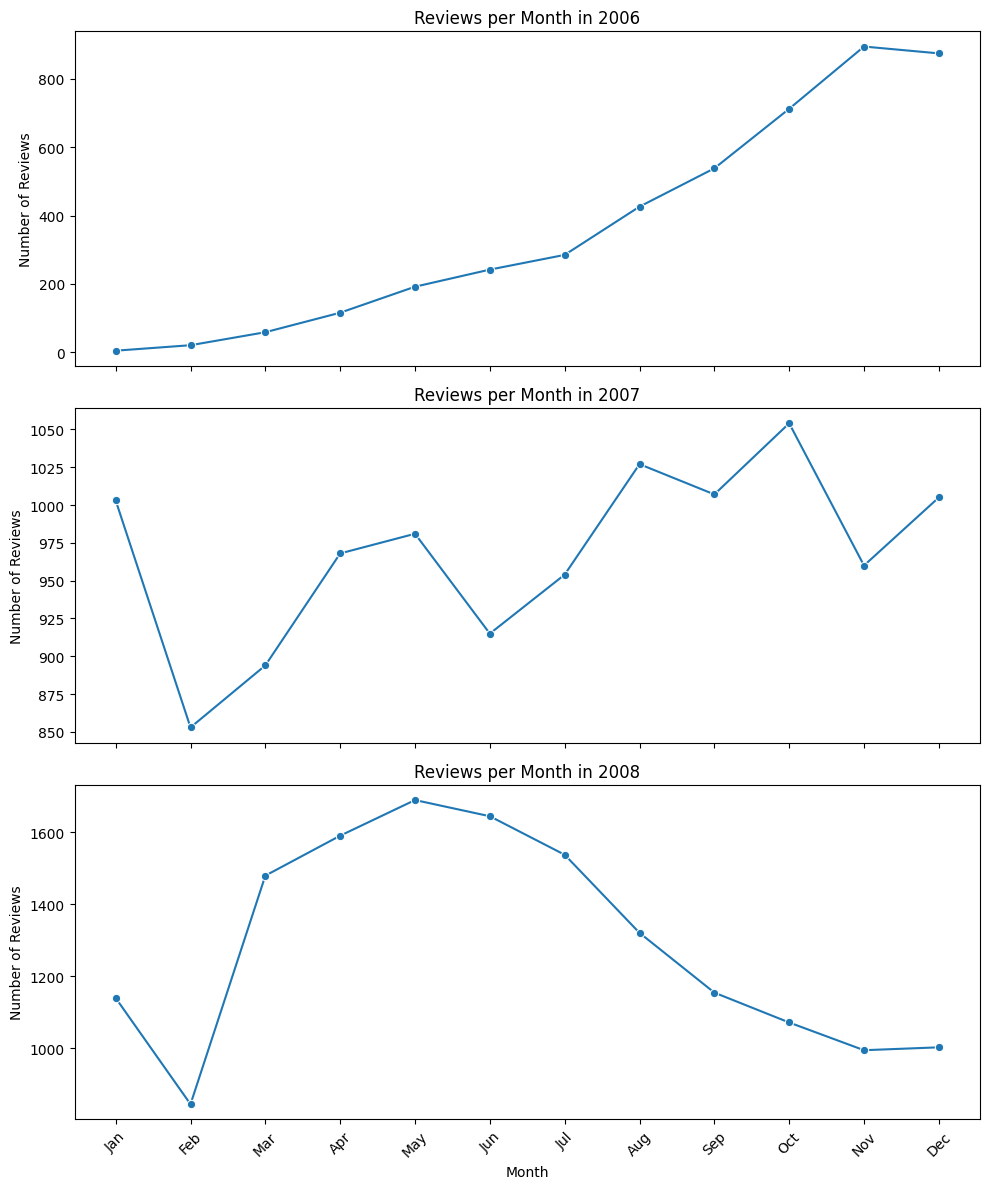

In [87]:


df['year_reviewed'] = df['date'].dt.year
df['month'] = df['date'].dt.month

counts = (
    df.groupby(['year_reviewed','month'])
      .size()
      .reset_index(name='n_reviews')
)

# 4) Set up subplots
years = [2006, 2007, 2008, 2009, 2010] # изненадващо има ревюта и от 2006 - за коли от бъдещето...
fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(10, 12),
    sharex=True
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax, year in zip(axes, years):
    data = counts[counts['year_reviewed'] == year]
    sns.lineplot(
        data=data,
        x='month', y='n_reviews',
        marker='o',
        ax=ax
    )
    ax.set_title(f'Reviews per Month in {year}')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_names, rotation=45)
    ax.set_ylabel('Number of Reviews')

axes[-1].set_xlabel('Month')

plt.tight_layout()
plt.show()

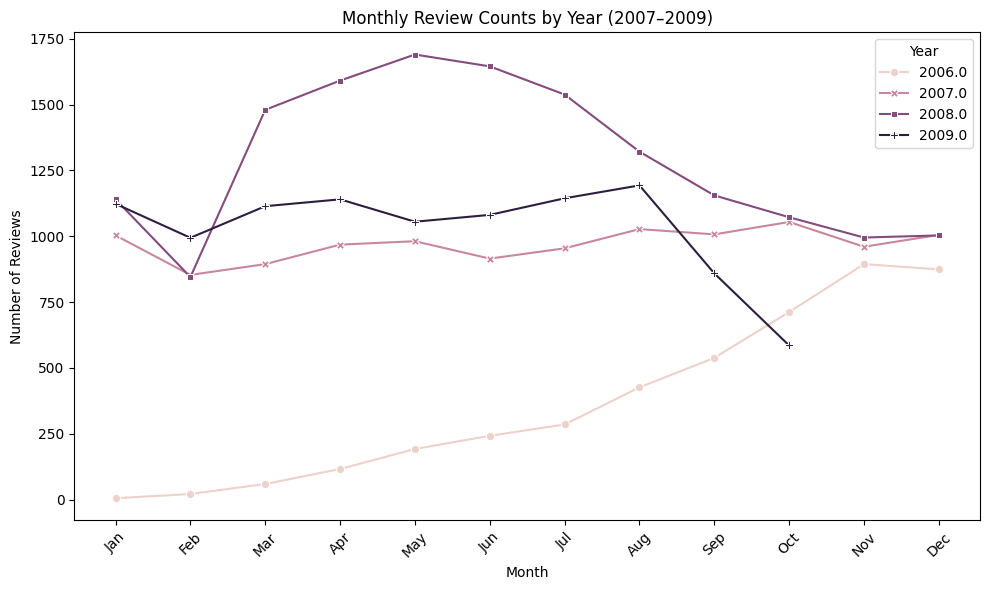

In [74]:

counts = (
    df.groupby(['year_reviewed','month'])  # Updated from 'year' to 'year_reviewed'
      .size()
      .reset_index(name='n_reviews')
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=counts,
    x='month', y='n_reviews',
    hue='year_reviewed',  # Updated from 'year' to 'year_reviewed'
    style='year_reviewed',  # Updated from 'year' to 'year_reviewed'
    markers=True,
    dashes=False
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks=range(1,13), labels=month_names, rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Review Counts by Year (2007–2009)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

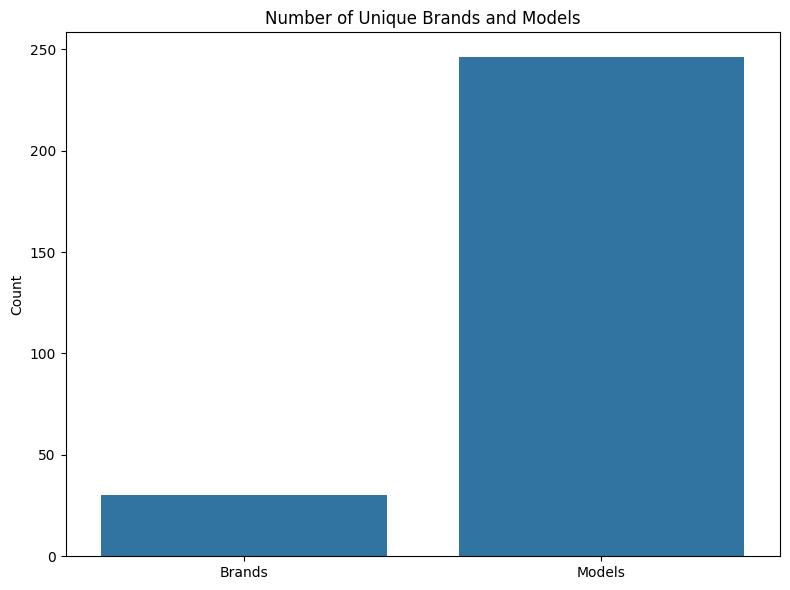

In [75]:
# Count unique brands and models
brand_count = df['brand'].nunique()
model_count = df['model'].nunique()

# Create data for the bar chart
categories = ['Brands', 'Models']
counts = [brand_count, model_count]

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts)
plt.title('Number of Unique Brands and Models')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

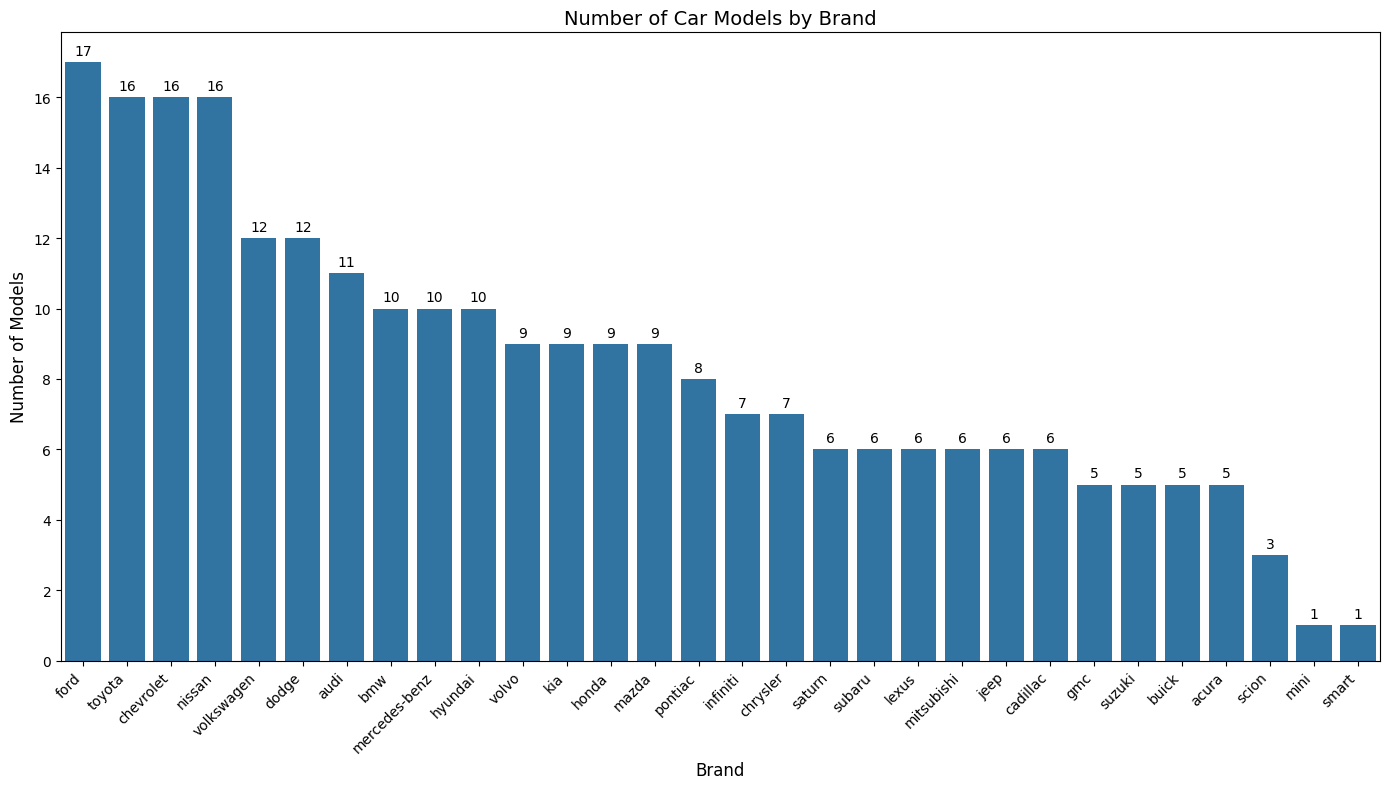

In [85]:
# Count number of unique models by brand
models_by_brand = df.groupby('brand')['model'].nunique().reset_index()
models_by_brand.columns = ['Brand', 'Number of Models']

# Sort by number of models descending
models_by_brand = models_by_brand.sort_values('Number of Models', ascending=False)

# Create the bar chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=models_by_brand, x='Brand', y='Number of Models')

# Add title and labels
plt.title('Number of Car Models by Brand', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for i, bar in enumerate(ax.patches):
    count = models_by_brand.iloc[i]['Number of Models']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

# Adjust layout
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

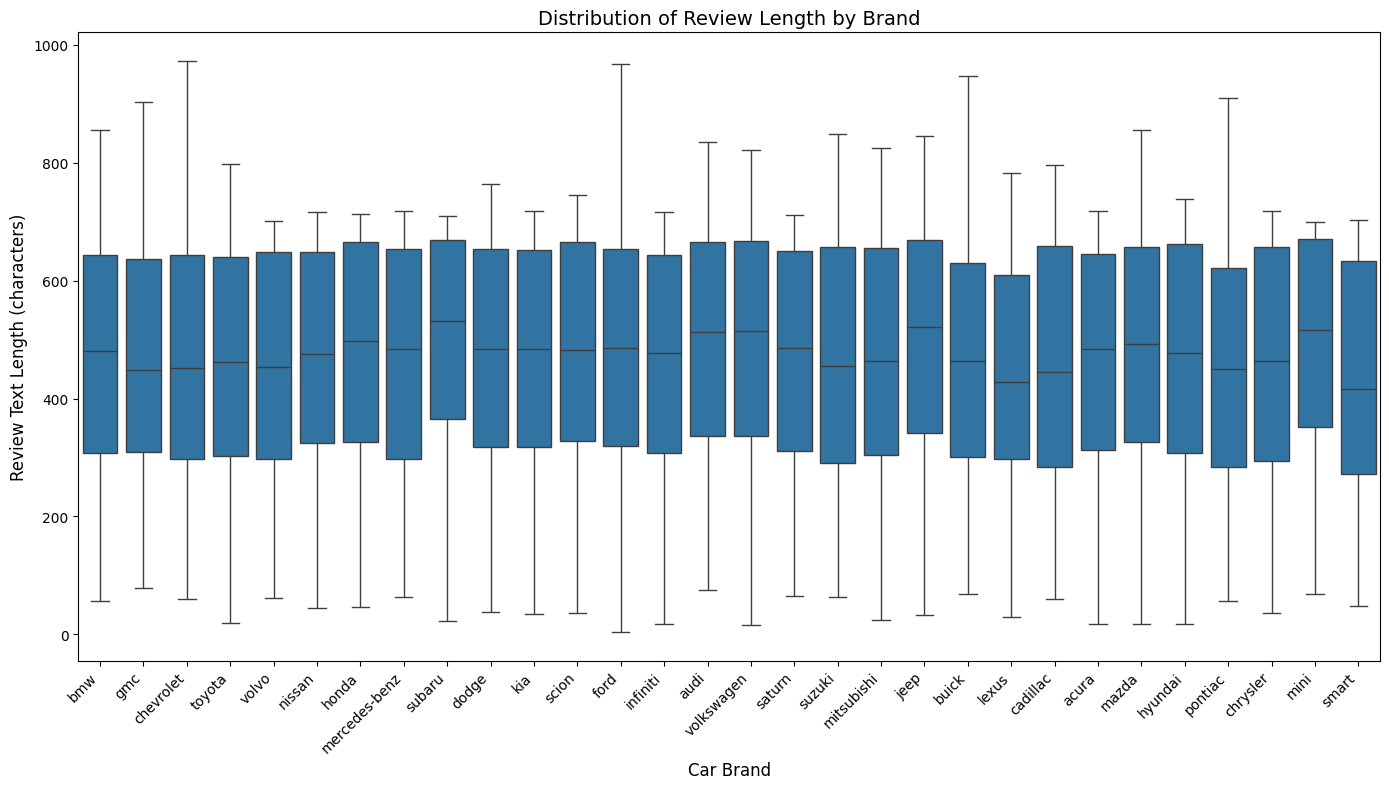

In [76]:
# Calculate text lengths
df['text_len'] = df['text'].str.len()

# Create a larger figure
plt.figure(figsize=(14, 8))

# Create the boxplot
ax = sns.boxplot(data=df, x='brand', y='text_len')

# Improve x-axis labels
plt.xticks(rotation=45, ha='right')
plt.xlabel('Car Brand', fontsize=12)
plt.ylabel('Review Text Length (characters)', fontsize=12)
plt.title("Distribution of Review Length by Brand", fontsize=14)

# Add more space at bottom for labels
plt.subplots_adjust(bottom=0.2)

# Adjust layout
plt.tight_layout()

plt.show()

In [77]:
# This line has the error - fixing it and updating to use year_reviewed
agg = df.groupby(['brand', df['date'].dt.year.rename('year_reviewed')])['sentiment'].mean().reset_index()

# Rename the year column for clarity
agg.columns = ['brand', 'year_reviewed', 'sentiment']  # Updated from 'year' to 'year_reviewed'

# Now plot with the correct dataframe structure
sns.lineplot(data=agg, x='year_reviewed', y='sentiment', hue='brand', marker='o')  # Updated from 'year' to 'year_reviewed'
plt.title("Avg. Sentiment by Brand & Year")

KeyError: 'Column not found: sentiment'

In [ ]:
%%sql


In [78]:
# Display rows with null values
null_rows = df[df.isna().any(axis=1)]
print(f"Number of rows with null values: {len(null_rows)}")
display(null_rows)

# Check for empty strings
empty_text_rows = df[(df['text'] == '') |
                     (df['author'] == '') |
                     (df['favorite'] == '')]
print(f"Number of rows with empty text fields: {len(empty_text_rows)}")
display(empty_text_rows)

Number of rows with null values: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
325,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
326,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
327,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
328,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
329,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
860,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
861,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
862,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
863,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Number of rows with empty text fields: 1631


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
41,2008-03-21,unhappy Jess,"Start with my X5 has only 3500 miles in it, at...",,x5,bmw,2008,2008.0,3.0,337.0
63,2009-07-09,DT,They just keep getting better. I had a Tahoe a...,,suburban,chevrolet,2008,2009.0,7.0,501.0
158,2007-12-10,retired_newmex,Fantastic truck. Lo-4 a little tricky to engag...,,tacoma,toyota,2008,2007.0,12.0,57.0
165,2007-09-28,jay,The best truck on the market. The ride is amaz...,,tacoma,toyota,2008,2007.0,9.0,354.0
185,2009-07-24,Hatchback,I expected more from a nissan. It has been in ...,,versa,nissan,2008,2009.0,7.0,382.0
...,...,...,...,...,...,...,...,...,...,...
42101,2009-04-18,sketchbone,Bought a black 1LT manual earlier today and I'...,,corvette,chevrolet,2009,2009.0,4.0,694.0
42117,2009-09-25,Becky,Love my new Murano! I got the S AWD with the c...,,murano,nissan,2009,2009.0,9.0,242.0
42222,2009-03-02,Lillie,I noticed in some old entries that Wind noise ...,,murano,nissan,2009,2009.0,3.0,337.0
42255,2008-09-16,goodday,Traded in a Quest van. Nissan really ramped up...,,murano,nissan,2009,2008.0,9.0,331.0


In [79]:
# Display rows where date is NaT
date_missing = df[df['date'].isna()]
print(f"Number of rows with missing dates: {len(date_missing)}")
display(date_missing)

# Filter out rows with NaT dates
df_filtered = df.dropna(subset=['date'])
print(f"Original dataframe shape: {df.shape}")
print(f"Filtered dataframe shape: {df_filtered.shape}")
print(f"Removed {df.shape[0] - df_filtered.shape[0]} rows with missing dates")

Number of rows with missing dates: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
325,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
326,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
327,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
328,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
329,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
860,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
861,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
862,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
863,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Original dataframe shape: (42288, 10)
Filtered dataframe shape: (41748, 10)
Removed 540 rows with missing dates


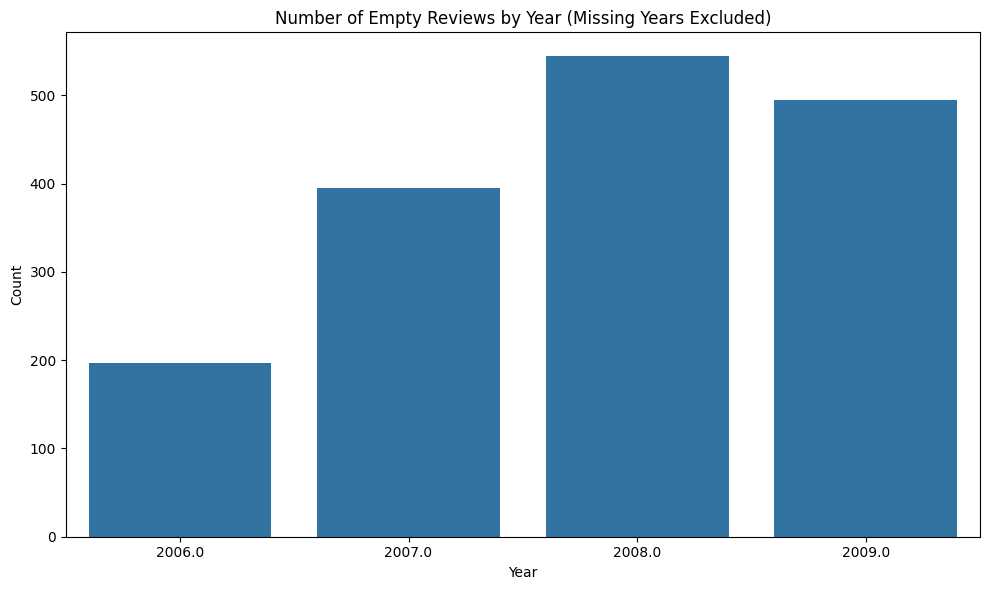

In [80]:
# Plot 1: Number of empty reviews per year
# Empty reviews are those with at least one empty field
empty_reviews = df[(df.isna().any(axis=1)) |
                   (df['text'] == '') |
                   (df['author'] == '') |
                   (df['favorite'] == '')]

# Create a copy to avoid SettingWithCopyWarning
empty_reviews_filtered = empty_reviews.dropna(subset=['year_reviewed']).copy()

# Group by year and count
empty_by_year = empty_reviews_filtered.groupby('year_reviewed').size().reset_index(name='count')

# Plot the filtered data
plt.figure(figsize=(10, 6))
sns.barplot(data=empty_by_year, x='year_reviewed', y='count')
plt.title('Number of Empty Reviews by Year (Missing Years Excluded)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Average reviews per day: 31.04


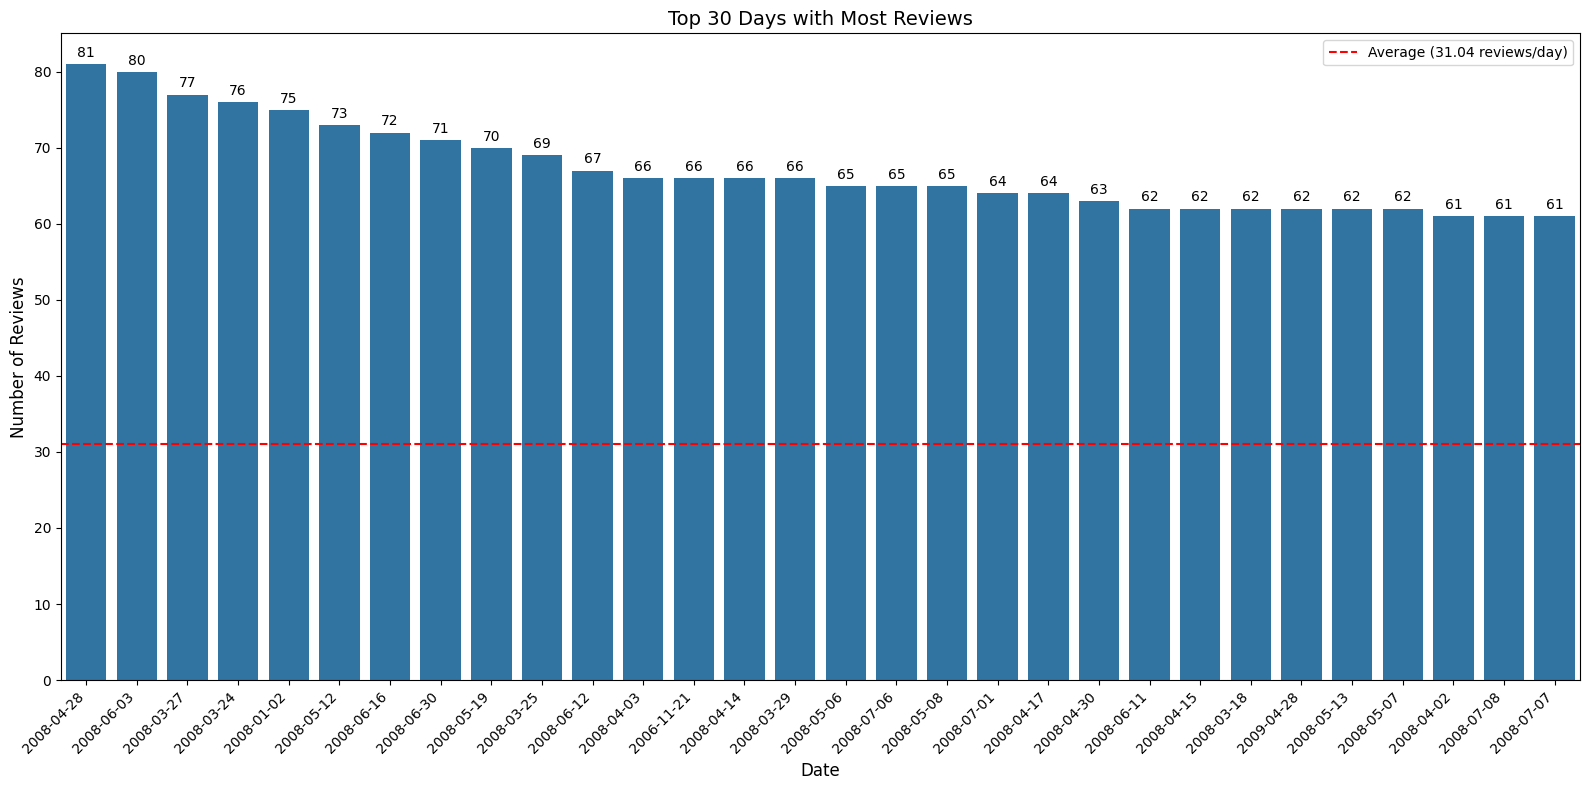

In [91]:
# Group reviews by day
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

# Calculate average reviews per day
avg_reviews_per_day = reviews_per_day['reviews'].mean()
print(f"Average reviews per day: {avg_reviews_per_day:.2f}")


# Find top 30 days with most reviews
top_30_days = reviews_per_day.sort_values('reviews', ascending=False).head(30)

plt.figure(figsize=(16, 8))  # Larger figure to fit more bars
ax = sns.barplot(data=top_30_days, x='date', y='reviews')

# Add a horizontal line for the average
ax.axhline(y=avg_reviews_per_day, color='r', linestyle='--',
           label=f'Average ({avg_reviews_per_day:.2f} reviews/day)')


# Add title and labels
plt.title('Top 30 Days with Most Reviews', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()

# Add count labels on top of each bar
for i, bar in enumerate(ax.patches):
    count = top_30_days.iloc[i]['reviews']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

# Adjust layout
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

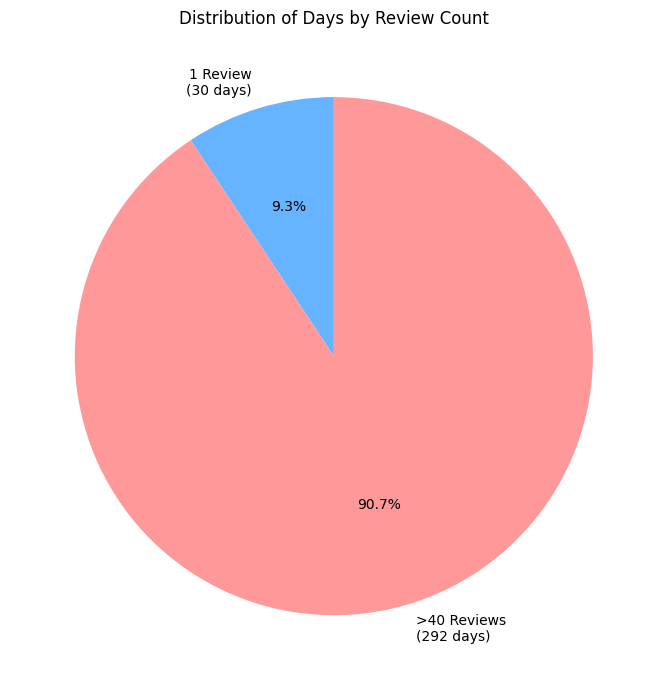

In [94]:
import matplotlib.pyplot as plt

# Group reviews by day
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

# Count days with 1 review and days with >40 reviews
days_with_1_review = (reviews_per_day['reviews'] == 1).sum()
days_with_over_40_reviews = (reviews_per_day['reviews'] > 40).sum()

# Prepare data
categories = ['1 Review', '>40 Reviews']
counts = [days_with_1_review, days_with_over_40_reviews]

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=[f"{cat}\n({cnt} days)" for cat, cnt in zip(categories, counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999']
)
plt.title('Distribution of Days by Review Count')
plt.tight_layout()
plt.show()

In [95]:
# explode the favorites into one row per feature and truncate to first 30 chars
# df_feat = (
#     df.assign(fav_list=df['favorite'].str.split(','))
#       .explode('fav_list')
#       .assign(fav_list=lambda d: d['fav_list'].str.strip().str.lower())
#       .assign(fav_list=lambda d: d['fav_list'].str[:30])  # Truncate to first 30 chars
# )
# pivot = (
#     df_feat.groupby(['model','fav_list'])
#            .size()
#            .unstack(fill_value=0)
# )
#
# # Create the heatmap with improved display settings
# plt.figure(figsize=(14, 10))  # Larger figure size for better readability
# sns.heatmap(pivot, cmap='YlOrRd', annot=False)
# plt.title("Favorite Features by Model (First 30 Characters)")
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust layout to fit all labels
# plt.show()


In [ ]:
# Count the number of unique favorites
unique_favorites_count = df['favorite'].nunique()
print(f"Number of unique favorites: {unique_favorites_count}")

# Get counts of each unique favorite
favorite_counts = df['favorite'].value_counts().reset_index()
favorite_counts.columns = ['Favorite', 'Count']

# Display the counts as a table
print("\nTop favorites and their counts:")
display(favorite_counts.head(10))  # Show top 10 favorites

# Visualize the counts (top 15 for readability)
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=favorite_counts.head(15), x='Favorite', y='Count')
plt.title('Most Common Favorites', fontsize=14)
plt.xlabel('Favorite', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for i, bar in enumerate(ax.patches):
    count = favorite_counts.iloc[i]['Count']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_35532/409766418.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_35532/409766418.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')


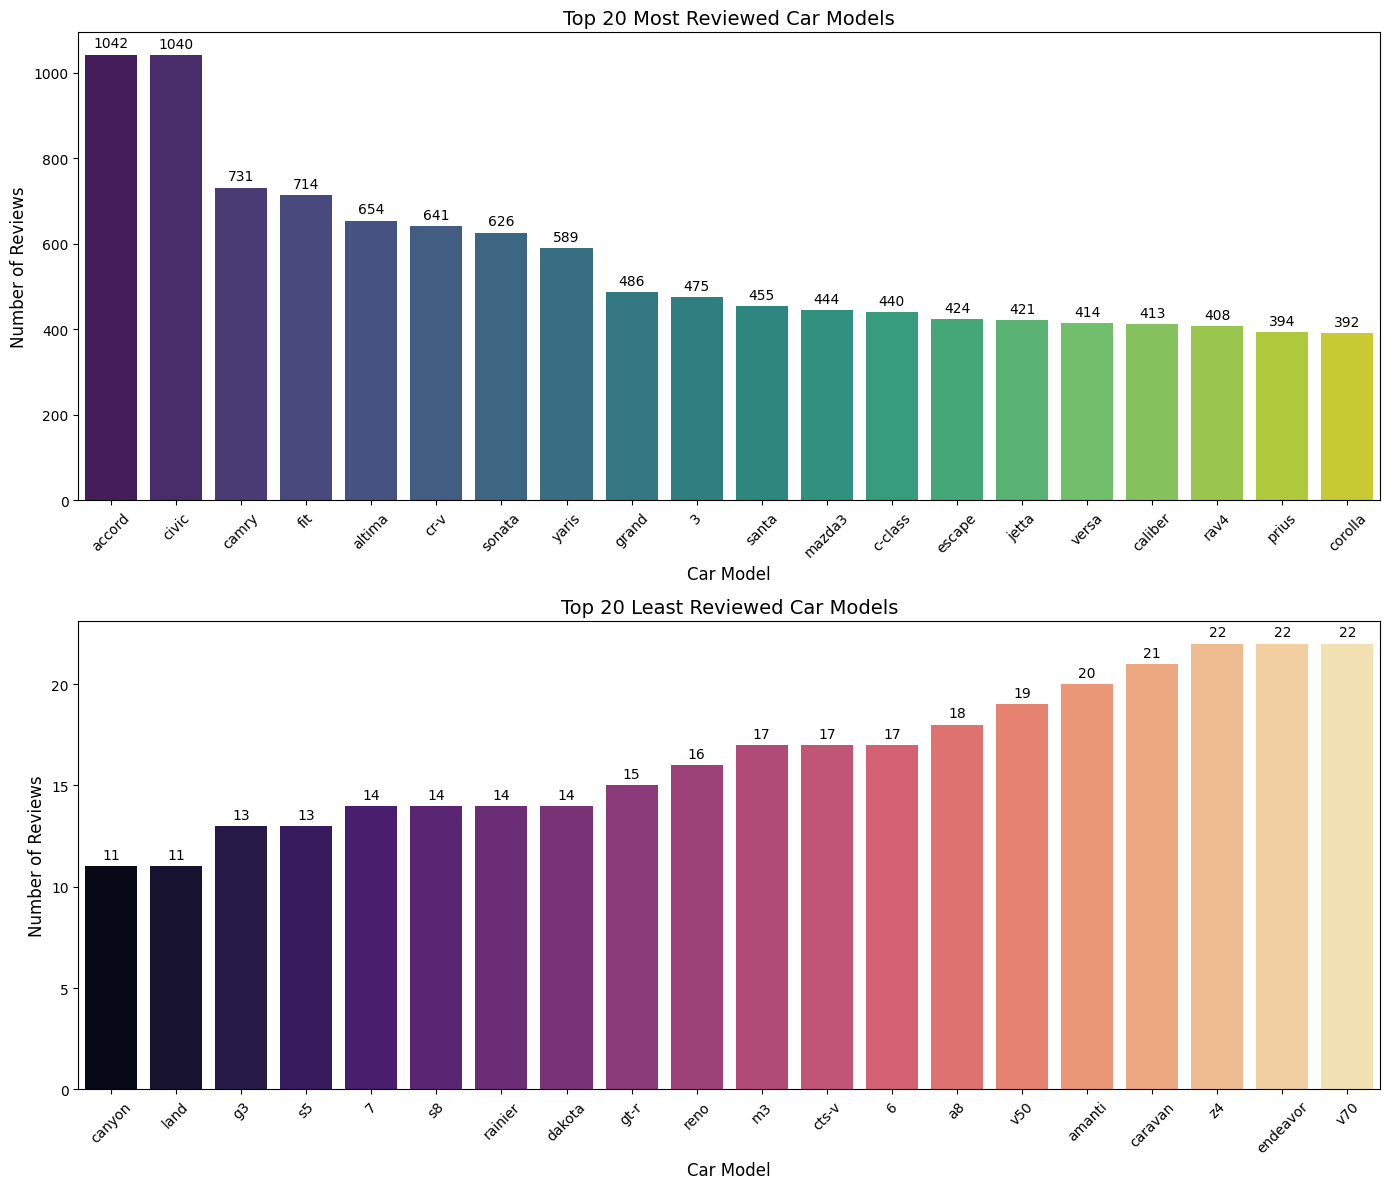

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count reviews per model
model_review_counts = df.groupby('model').size().reset_index(name='count')

# Sort by count to get most and least reviewed models
most_reviewed = model_review_counts.sort_values('count', ascending=False).head(20)
least_reviewed = model_review_counts.sort_values('count').head(20)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot most reviewed models
sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Most Reviewed Car Models', fontsize=14)
axes[0].set_xlabel('Car Model', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Add count labels on top of each bar for most reviewed
for i, bar in enumerate(axes[0].patches):
    count = most_reviewed.iloc[i]['count']
    axes[0].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

# Plot least reviewed models
sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')
axes[1].set_title('Top 20 Least Reviewed Car Models', fontsize=14)
axes[1].set_xlabel('Car Model', fontsize=12)
axes[1].set_ylabel('Number of Reviews', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Add count labels on top of each bar for least reviewed
for i, bar in enumerate(axes[1].patches):
    count = least_reviewed.iloc[i]['count']
    axes[1].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

